In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


# sc_min

## xgboost

In [4]:
TARGET = 'sc_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4']

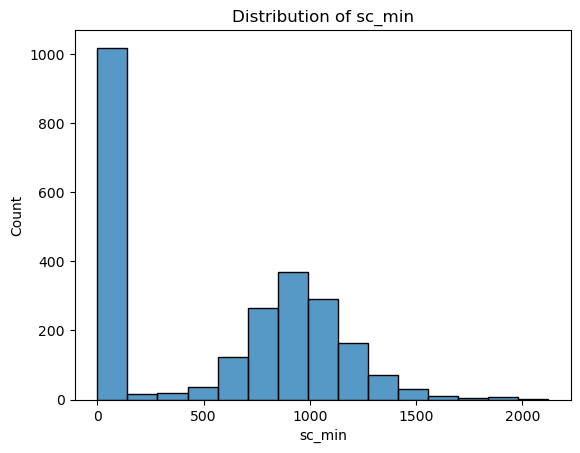

In [5]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)

y_train = np.log10(df_train[TARGET].to_numpy())
y_valid = np.log10(df_valid[TARGET].to_numpy())
y_test = np.log10(df_test[TARGET].to_numpy())

df_zero = df_zero.drop([TARGET], axis = 1)
df_train = df_train.drop([TARGET], axis = 1)
df_valid = df_valid.drop([TARGET], axis = 1)
df_test = df_test.drop([TARGET], axis = 1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(846, 270) (212, 270) (361, 270) (1010, 270)


C:\Users\emanu\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


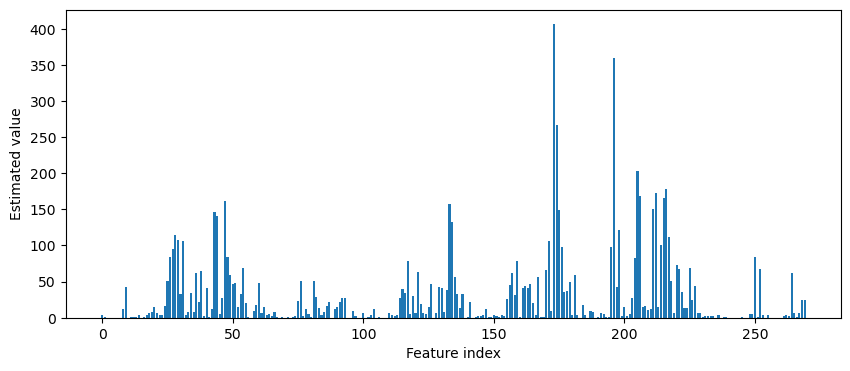

In [7]:
f_selector = SelectKBest(score_func = f_regression, k = 'all')
f_selector.fit(X_train, y_train)

plt.figure(figsize = (10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.show()

In [8]:
f_selector = SelectKBest(score_func = f_regression, k = 6)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_train.iloc[:, selected_indices]

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


,sc_q01_w3,sc_q05_w3,zc_skew_w4,mfcc_q50_w4,sc_mean_w4,sc_q50_w4
259,1116.033592,1212.215438,3.595123,0.165307,5969.642045,6715.742193
157,823.486138,876.608240,2.865589,7.206193,9473.160757,9486.159409
666,937.444068,1053.909013,5.393879,3.266991,5955.103973,6417.093634
706,988.643551,1105.591378,2.177453,0.558810,7932.804161,8539.486708
125,1443.575892,1506.453749,2.568561,3.373528,8759.006889,8956.546266
...,...,...,...,...,...,...
802,1445.561087,1527.545274,4.072133,1.887486,7244.738042,8608.471301
53,1465.527018,1518.101121,6.126823,6.565955,3463.667499,2882.258032
350,734.623135,875.756307,3.562200,6.325346,6808.103625,7248.399038
79,1296.712995,1412.026850,2.253350,-0.111700,5573.463790,5067.190814


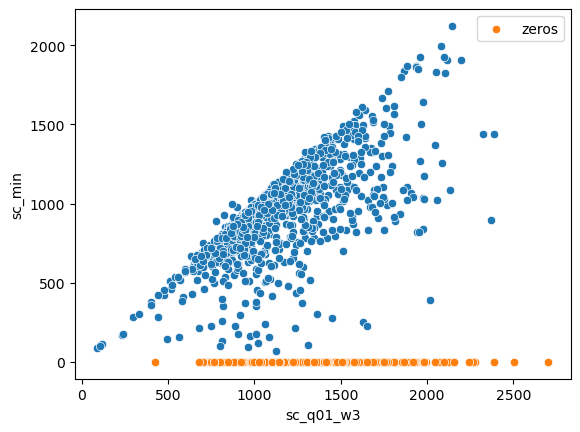

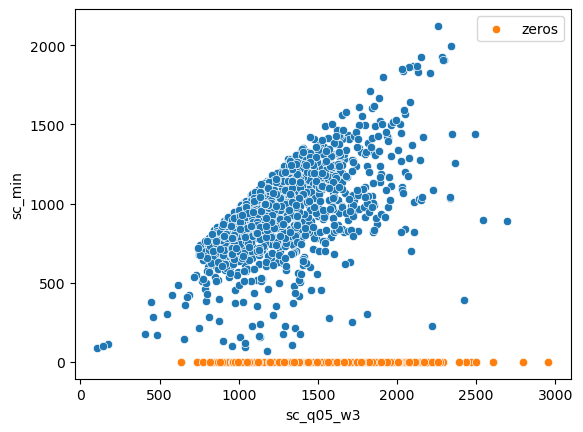

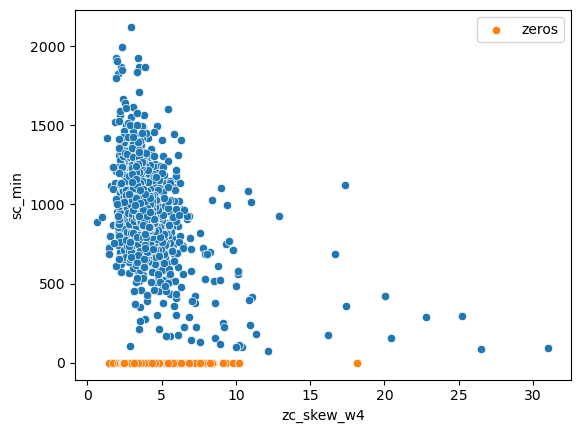

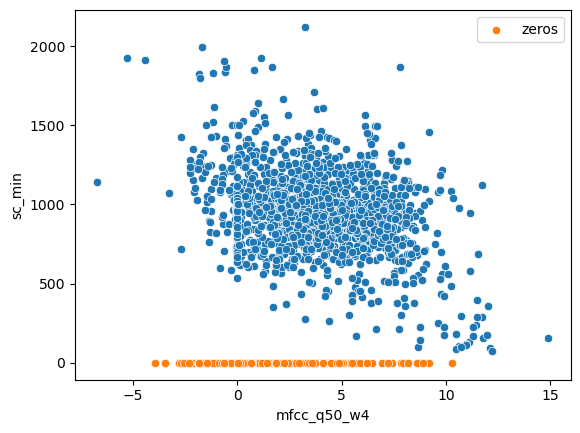

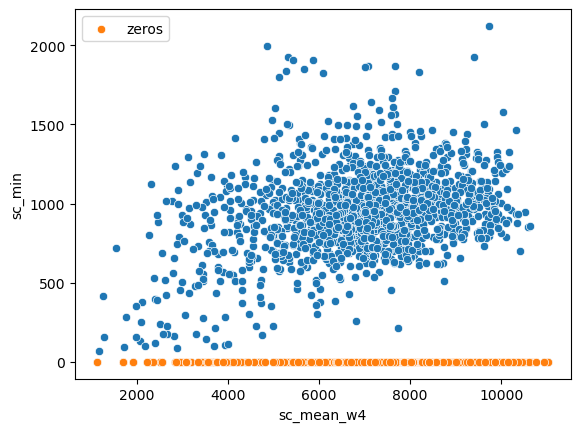

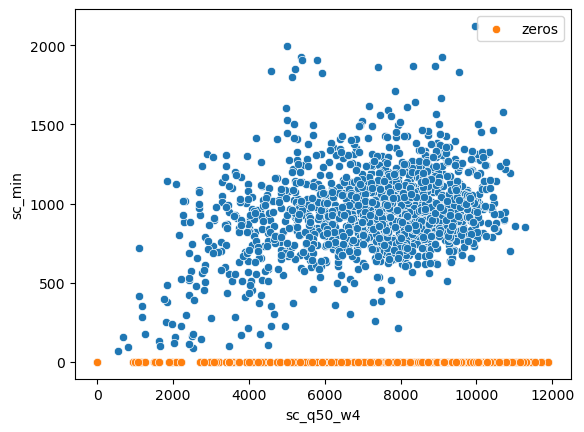

In [11]:
cols=list(df_train.iloc[:, selected_indices].columns)

for col in cols:
    sns.scatterplot(data = df_reg, y = TARGET, x = col)
    sns.scatterplot(data = df_reg[df_reg[TARGET] == 0], y = TARGET, x = col, label = 'zeros')
    plt.legend()
    plt.show()

In [12]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0.01, 1)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials = 150, n_jobs = -1)

[I 2023-06-06 15:22:54,943] A new study created in memory with name: no-name-d1f69cfd-8253-4d12-b952-e2118af3ceaa
[I 2023-06-06 15:22:55,128] Trial 4 finished with value: 0.01720592087010765 and parameters: {'booster': 'gbtree', 'gamma': 1.5953791900968621, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8835146679201378}. Best is trial 4 with value: 0.01720592087010765.
[I 2023-06-06 15:22:55,396] Trial 3 finished with value: 0.026528754714802167 and parameters: {'booster': 'gbtree', 'gamma': 3.4870374464283267, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.6033025888606597}. Best is trial 4 with value: 0.01720592087010765.
[I 2023-06-06 15:22:55,536] Trial 1 finished with value: 0.02650405038910185 and parameters: {'booster': 'gbtree', 'gamma': 4.399238232834558, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.6461444534508597}. Best is trial 4 with value: 0.01720592087010765.
[I 2023-06-06 15:22:55,577] Trial 8 finished with value: 0.026750323700988392 and para

[I 2023-06-06 15:22:59,146] Trial 31 finished with value: 0.013921884546356691 and parameters: {'booster': 'gbtree', 'gamma': 0.7233803921319379, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.9326836364379908}. Best is trial 24 with value: 0.011494292985105584.
[I 2023-06-06 15:22:59,159] Trial 32 finished with value: 0.01380034517752805 and parameters: {'booster': 'gbtree', 'gamma': 0.8091825436652296, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.9350931895822663}. Best is trial 24 with value: 0.011494292985105584.
[I 2023-06-06 15:22:59,415] Trial 33 finished with value: 0.013534800268896849 and parameters: {'booster': 'gbtree', 'gamma': 0.759935233796416, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.9392584359800387}. Best is trial 24 with value: 0.011494292985105584.
[I 2023-06-06 15:23:00,165] Trial 34 finished with value: 0.013884624273741404 and parameters: {'booster': 'dart', 'gamma': 0.5890843762682301, 'max_depth': 14, 'min_child_weight': 2, 'subs

[I 2023-06-06 15:23:04,793] Trial 62 finished with value: 0.012460092450933989 and parameters: {'booster': 'dart', 'gamma': 0.222784426139782, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9789775120678117}. Best is trial 58 with value: 0.01024529264367286.
[I 2023-06-06 15:23:04,866] Trial 63 finished with value: 0.011903809356368502 and parameters: {'booster': 'dart', 'gamma': 0.2436302860713207, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9697516115914981}. Best is trial 58 with value: 0.01024529264367286.
[I 2023-06-06 15:23:04,882] Trial 64 finished with value: 0.011358195533654136 and parameters: {'booster': 'dart', 'gamma': 0.1411895670620179, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9689462931439766}. Best is trial 58 with value: 0.01024529264367286.
[I 2023-06-06 15:23:04,939] Trial 65 finished with value: 0.011511243500952088 and parameters: {'booster': 'dart', 'gamma': 0.1924407256235913, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 

[I 2023-06-06 15:23:09,694] Trial 94 finished with value: 0.012399468634141797 and parameters: {'booster': 'gbtree', 'gamma': 0.10398582819555714, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9533035101418882}. Best is trial 58 with value: 0.01024529264367286.
[I 2023-06-06 15:23:09,936] Trial 96 finished with value: 0.012129767553675432 and parameters: {'booster': 'gbtree', 'gamma': 0.10139665452356439, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9467452679053098}. Best is trial 58 with value: 0.01024529264367286.
[I 2023-06-06 15:23:10,158] Trial 92 finished with value: 0.013109630133341857 and parameters: {'booster': 'gbtree', 'gamma': 0.0012984844678819718, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.953062174408721}. Best is trial 58 with value: 0.01024529264367286.
[I 2023-06-06 15:23:10,276] Trial 97 finished with value: 0.013749036491039401 and parameters: {'booster': 'gbtree', 'gamma': 0.057092700080909886, 'max_depth': 10, 'min_child_weight': 2

[I 2023-06-06 15:23:16,989] Trial 121 finished with value: 0.012518030010090607 and parameters: {'booster': 'dart', 'gamma': 0.6867024462407738, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.9830141554181432}. Best is trial 114 with value: 0.009757560131363065.
[I 2023-06-06 15:23:17,125] Trial 126 finished with value: 0.01395887697670859 and parameters: {'booster': 'dart', 'gamma': 0.18772836565936826, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.9908023373650576}. Best is trial 114 with value: 0.009757560131363065.
[I 2023-06-06 15:23:17,127] Trial 127 finished with value: 0.014166418531764478 and parameters: {'booster': 'dart', 'gamma': 0.1358589829388597, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.9253238066242585}. Best is trial 114 with value: 0.009757560131363065.
[I 2023-06-06 15:23:17,228] Trial 123 finished with value: 0.012010571507513054 and parameters: {'booster': 'dart', 'gamma': 0.6798027157846893, 'max_depth': 20, 'min_child_weight': 2, 's

In [14]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'gbtree', 'gamma': 0.06249202841606935, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9706492409494533}
Root mean squared error = 0.2577
R-squared = -6.5686


In [15]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([ 398.61072,  369.5571 ,  398.61072, ..., 1046.0725 , 1268.0331 ,
       1111.2661 ], dtype=float32)

In [17]:
df_zero[TARGET] = y_pred
df.update(df_zero)

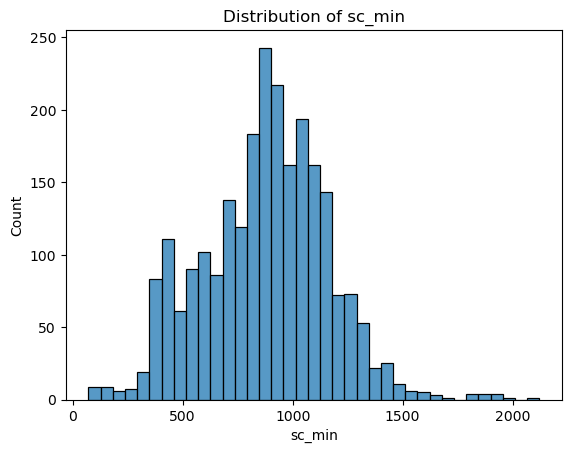

In [18]:
sns.histplot(data = df, x = TARGET)
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

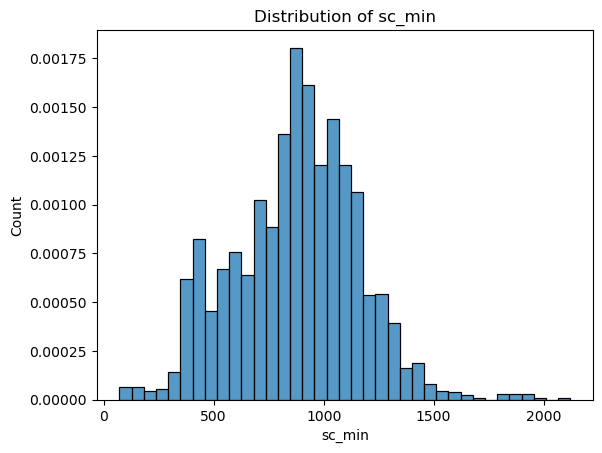

In [20]:
sns.histplot(data = df, x = TARGET, stat = 'density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

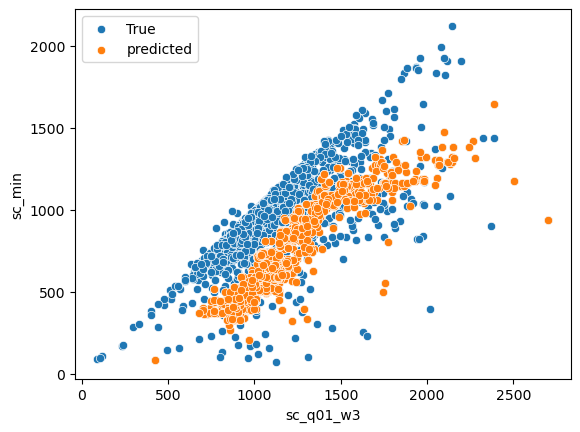

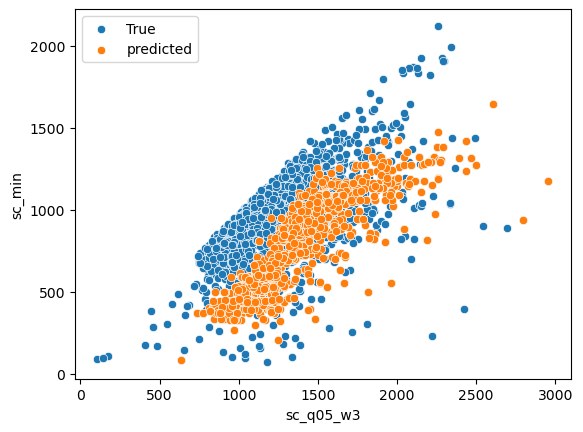

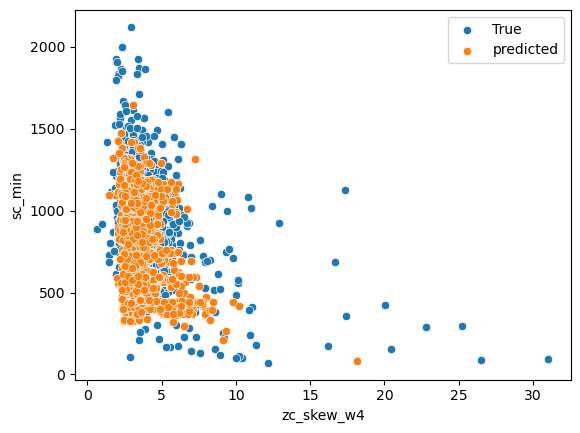

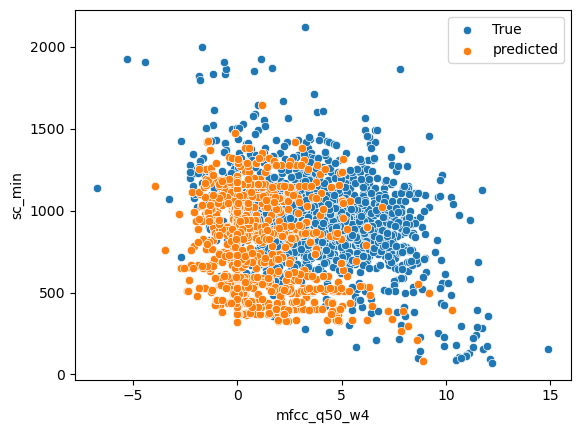

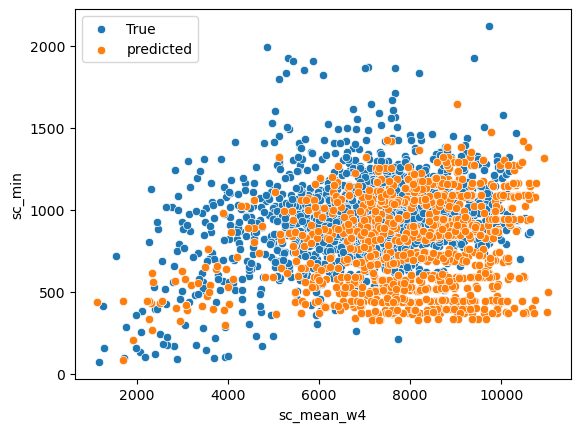

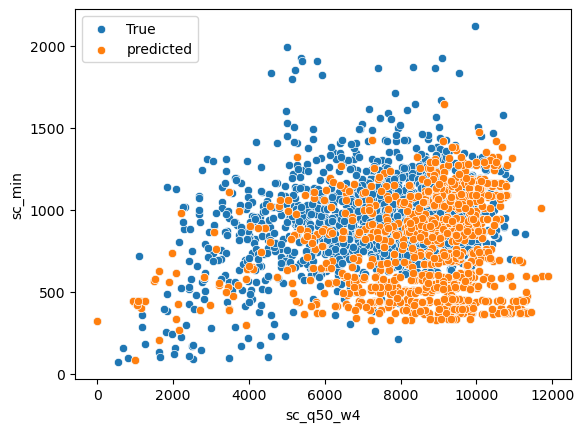

In [24]:
for col in cols:
    sns.scatterplot(data=df, y=TARGET, x=col, label='True')
    sns.scatterplot(data=df_zero,  y=y_pred, x=col, label='predicted')
    plt.legend()
    plt.show()

## random forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
regr = RandomForestRegressor(random_state = 0)

clf = GridSearchCV(regr, param_grid)
clf.fit(X_train, y_train)
print(clf.best_score_, clf.best_params_)

0.5356525583637668 {'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 30}


In [26]:
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.06345509923810884

In [27]:
rf = RandomForestRegressor(**clf.best_params_)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'gbtree', 'gamma': 0.06249202841606935, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9706492409494533}
Root mean squared error = 0.2671
R-squared = -7.1293


In [28]:
y_pred = rf.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([ 475.10754776,  363.835882  ,  433.71088717, ..., 1039.03725417,
       1106.08924837, 1110.07551282])

In [30]:
df_zero[TARGET] = y_pred
df.update(df_zero)

<AxesSubplot:xlabel='sc_min', ylabel='Density'>

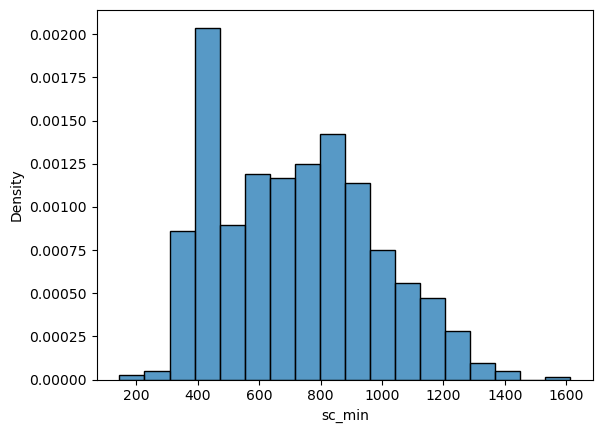

In [31]:
sns.histplot(data = df_zero, x = TARGET, stat = 'density')

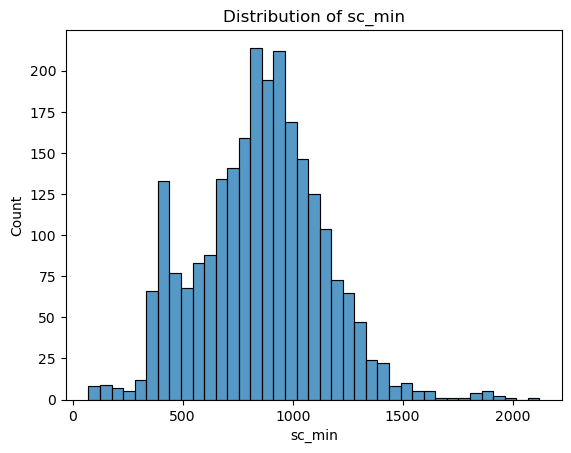

In [32]:
sns.histplot(data = df, x = TARGET)
plt.xlabel(TARGET)
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

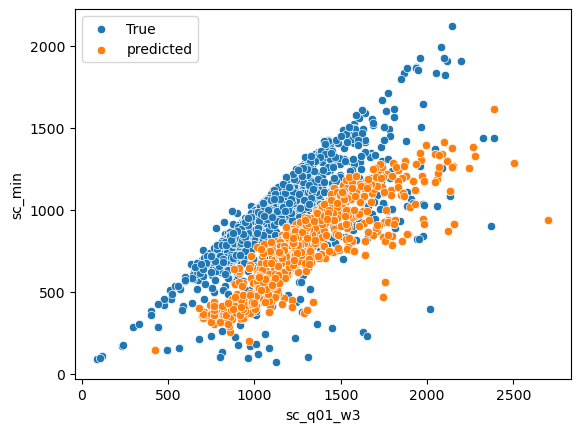

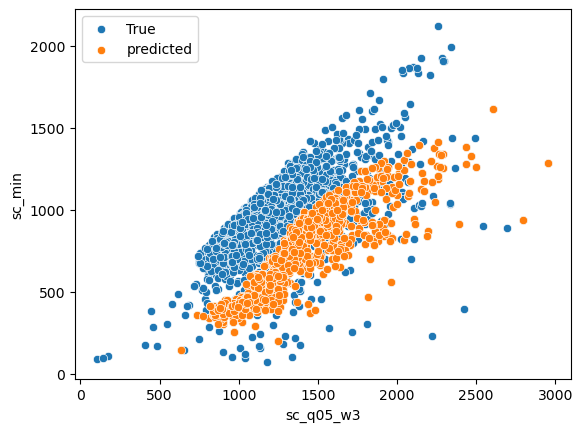

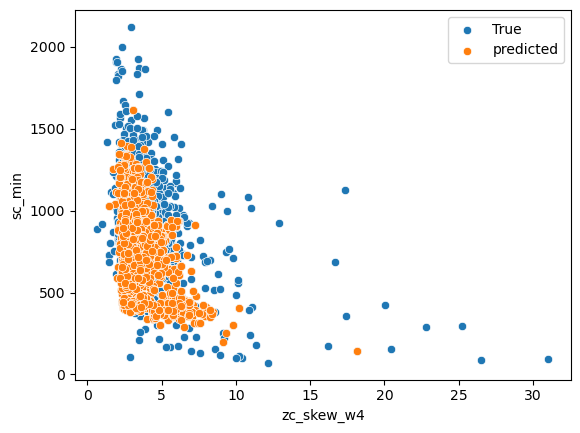

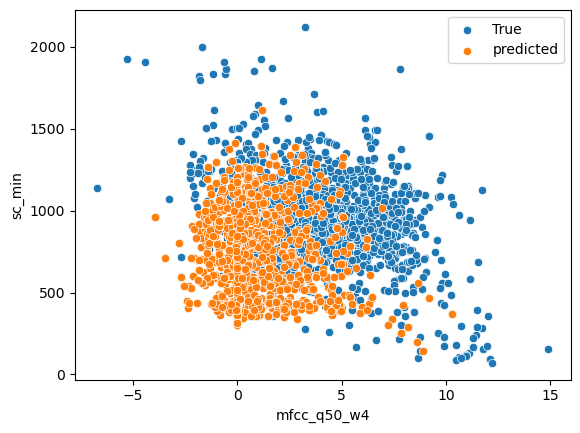

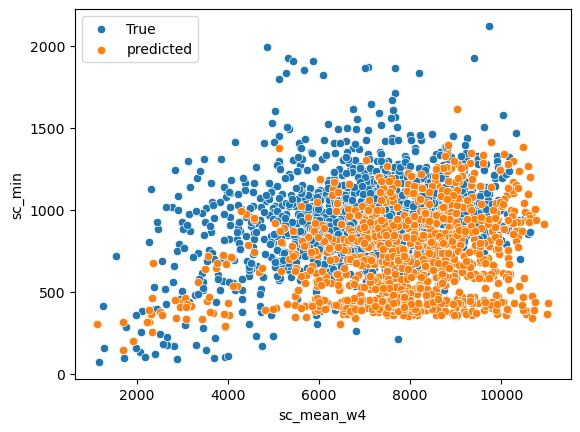

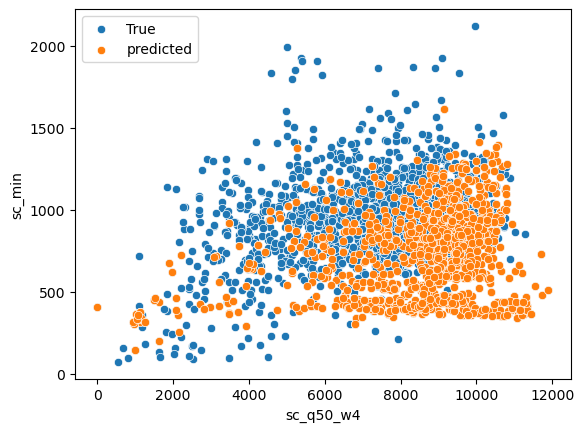

In [33]:
for col in cols:
    sns.scatterplot(data = df, y = TARGET, x = col, label = 'True')
    sns.scatterplot(data = df_zero,  y = y_pred, x = col, label = 'predicted')
    plt.legend()
    plt.show()